Mounted at /content/drive
                         ts               ip  page_view_order_number  \
5249    2024-10-09 08:17:44     62.118.81.61                       3   
6134    2024-10-09 08:17:52    89.113.137.32                       1   
14130   2024-10-09 08:18:59    176.59.111.86                       1   
14605   2024-10-09 08:19:04    91.244.168.54                       1   
16190   2024-10-09 08:19:18     87.255.17.12                       1   
...                     ...              ...                     ...   
9536317 2024-10-09 19:55:36    95.55.238.153                       1   
9537182 2024-10-09 19:55:44    95.55.238.153                       2   
9537460 2024-10-09 19:55:47  178.163.215.211                       1   
9537724 2024-10-09 19:55:49    95.55.238.153                       3   
9538320 2024-10-09 19:55:54    95.55.238.153                       4   

         event_order_number      event  secs  \
5249                     12  page_view     0   
6134         

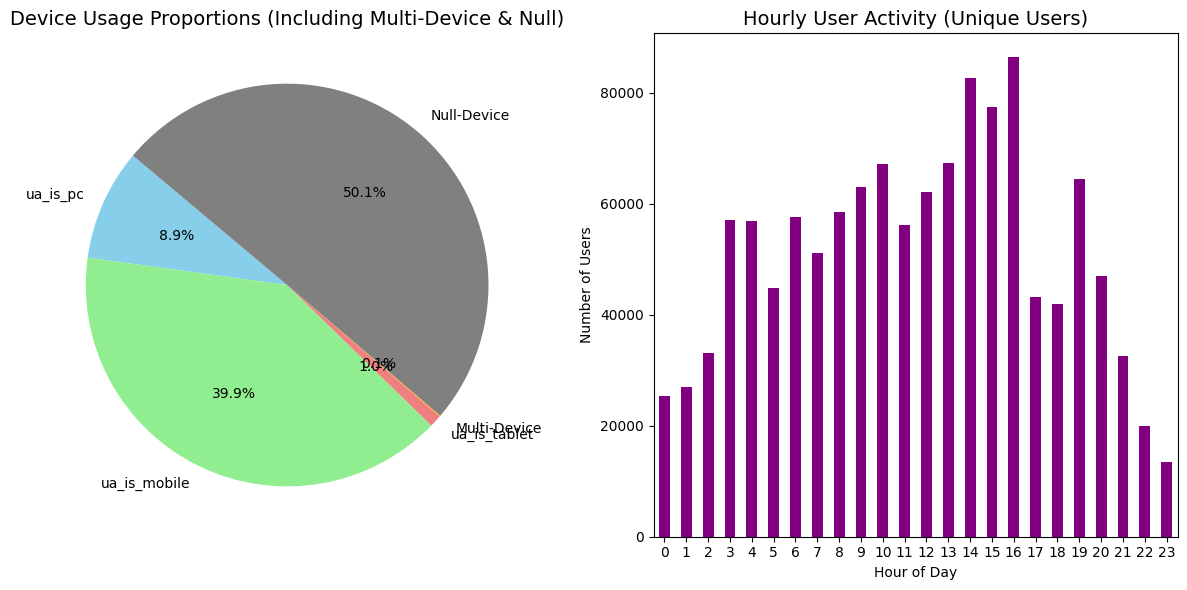

In [22]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for NaN checks


def load_data(file_path):
    """Loads data from a Parquet file and returns a Pandas DataFrame."""
    try:
        df = pd.read_parquet(file_path)
        df['ts'] = pd.to_datetime(df['ts'])
        return df
    except Exception as e:
        print(f"Error loading {e}")
        return None


def analyze_device_usage(df):
    """Analyzes device usage, identifying multi-device users, those with null flags, and creates a summary."""

    required_columns = ['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile', 'randPAS_session_id', 'ts']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: DataFrame must contain columns {required_columns} for device analysis.")
        return None  # Important: Return None if columns are missing

    # 1. Check for data inconsistencies (multiple device flags)
    simultaneous_device_mask = (df[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].sum(axis=1) > 1)
    if simultaneous_device_mask.any():
        print("Warning: Some rows have more than one device flag set to 1. Possible data quality issue.")
        print(df[simultaneous_device_mask])

    # 2. Identify Multi-Device Users (correct calculation for proper counts).

    # Correct multi-device determination (users that have records from different devices)

    multi_device_users = df.groupby('randPAS_session_id')[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].max()  # Determine if user *ever* used each device
    multi_device_users['device_count'] = multi_device_users.sum(axis=1)
    multi_device_users = multi_device_users[multi_device_users['device_count'] > 1]
    num_multi_device_users = len(multi_device_users)

    # 3. Identify Users with NULL device flags

    null_device_users = df[df[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].isnull().all(axis=1)]['randPAS_session_id'].nunique() # Count users

    # 4. Calculate Single Device Proportions (per unique user) for the piechart
    single_device_users = df.groupby('randPAS_session_id')[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].max() #Max as if ever used then they count as this. sum will double count users in multiple rows.
    single_device_proportions = single_device_users.sum() / df['randPAS_session_id'].nunique() #Divided by the total unique user passport IDs

    single_device_proportions['Multi-Device'] = num_multi_device_users / df['randPAS_session_id'].nunique()
    single_device_proportions['Null-Device'] = null_device_users / df['randPAS_session_id'].nunique() # Add the null proportion to the visual

    # Reorder for more readable chart
    single_device_proportions = single_device_proportions[['ua_is_pc', 'ua_is_mobile', 'ua_is_tablet', 'Multi-Device', 'Null-Device']]

    # 5. Create hourly user data for plotting
    hourly_data = df.groupby(df['ts'].dt.hour)['randPAS_session_id'].nunique()  #Count the unique users at each hour

    #6: Store results in a dictionary, returning the series of user information, hourly series, and device proportions.
    analysis_results = {
        'device_proportions': single_device_proportions,
        'hourly_data': hourly_data,
    }

    return analysis_results


def visualize_device_usage(analysis_results):
    """Visualizes device usage proportions and hourly activity."""
    device_proportions = analysis_results['device_proportions']
    hourly_data = analysis_results['hourly_data']

    # 1. Device Proportions Pie Chart
    plt.figure(figsize=(12, 6))  #Enlarge figure
    plt.subplot(1, 2, 1)  # Divide the figure into 1 row, 2 columns, and select the first subplot
    device_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140,
                              colors=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'gray'])  # Add color for null
    plt.title('Device Usage Proportions (Including Multi-Device & Null)', fontsize=14)  # Reduce size
    plt.ylabel('')

    # 2. Hourly User Activity Bar Chart
    plt.subplot(1, 2, 2)  # Select the second subplot
    hourly_data.plot(kind='bar', color='purple')
    plt.title('Hourly User Activity (Unique Users)', fontsize=14) # Reduce size
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Users')
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal

    plt.tight_layout()  # Adjust layout to prevent labels overlapping
    plt.show()



def main(file_path):
    """Main function to load data, analyze device usage, and visualize results."""
    df = load_data(file_path)

    if df is not None:  # Proceed only if loading data was successful
        analysis_results = analyze_device_usage(df)

        if analysis_results is not None: #Proceed only if analyze results exist
            visualize_device_usage(analysis_results) # Visualize using the results

# Example usage (Colab specific)
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/dataset/data_2024-10-09.parquet'  # Replace with your actual path
main(file_path)
